In [18]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

##### Define for user #####
root_df = 'D:/PYTHON/Data_ML/'
root_models = 'D:/PYTHON/Data_ML/'

In [23]:
df1=pd.read_pickle(root_df+"test.pickle") #Uniform distributed inputs

X = df1[["PSL_IP_1", "PSL_IP_2", "PSL_IP_3", "PSL_IP_4", "PSL_IP_5",
         "PSL_IP_6", "PSL_IP_7", "PSL_IP_8", "PSL_IP_9", "PSL_IP_10",
         "PSL_IP_11", "PSL_IP_12", "PSL_IP_13", "PSL_IP_14", "PSL_IP_15"]]

y = df1.drop(columns=["PSL_IP_1", "PSL_IP_2", "PSL_IP_3", "PSL_IP_4", "PSL_IP_5",
                      "PSL_IP_6", "PSL_IP_7", "PSL_IP_8", "PSL_IP_9", "PSL_IP_10",
                      "PSL_IP_11", "PSL_IP_12", "PSL_IP_13", "PSL_IP_14", "PSL_IP_15"])

# Normalisation des données
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)
#X_scaled = X
#y_scaled = y

# Sauvegarder le scaler
with open(root_models + 'gpy/' + 'scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)
with open(root_models + 'gpy/' + 'scaler_Y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)    

# Division des données en ensembles d'entraînement et de test
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle= True, random_state=42)

# Define the number of folds for cross-validation
k_folds = 20

#Putting the train data to the proper format
X_train=np.asarray(x_train).astype('float32')

y_train=np.asarray(y_train).astype('float32')
print(len(X_train))

968


In [24]:
kernel = Matern(length_scale=1, nu=2/5)

# RBF kernel is the only one supported by ONNX
# kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))


gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

Matern(length_scale=213, nu=0.4)

In [25]:
model_name='GP_small_test_div_rms'
with open(root_models+'gpy/'+model_name+'.pkl', 'wb') as file:
    pickle.dump(gaussian_process, file)

Test NN : 0.9820745605054637
Train NN : 0.9999999999468018


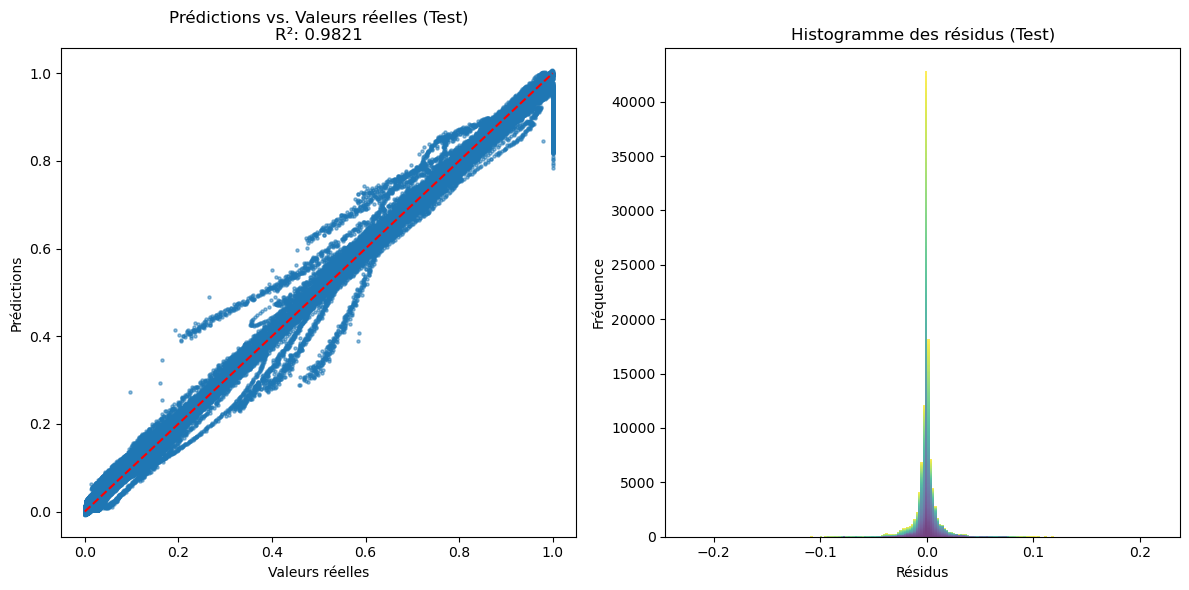

In [26]:
y_pred1_test = gaussian_process.predict(x_test)
y_pred_train = gaussian_process.predict(x_train)
#print(y_pred_train)

r2_test = r2_score(y_test, y_pred1_test)
print('Test NN :',r2_test)

r2_train = r2_score(y_train, y_pred_train)
print('Train NN :',r2_train)

# Visualisation des prédictions vs. valeurs réelles pour les données de test
plt.figure(figsize=(12, 6))

# Nuage de points des prédictions vs. valeurs réelles
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred1_test, alpha=0.5, s=5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title(f'Prédictions vs. Valeurs réelles (Test)\nR²: {r2_test:.4f}')

# Histogramme des résidus
plt.subplot(1, 2, 2)
residuals = y_test - y_pred1_test
colors = plt.cm.viridis(np.linspace(0, 1, residuals.shape[1]))  # Crée une liste de couleurs
plt.hist(residuals, bins=200, alpha=0.75, color=colors, stacked=True)
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.title('Histogramme des résidus (Test)')

plt.tight_layout()
plt.show()